# Stock prices prediction using recursive neural network 

In [17]:
import pandas as pd
import os 
from os import path 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Dropout 
import matplotlib.pyplot as plt 
import numpy as np 

## The function implements a trading strategy based on the prediction of stock market values 

In [18]:
def trading_with_prediction(data, Y_pred):
    #initial number of shares and cash 
    actions = 1000
    cash = 0
    cash_begin = data[0]*actions
    #I will save the data to a file 
    
    price_for_sell = 0
    price_for_buy = actions * data[0]
    good_deal = 0
    
    offset = 60 #the number of days back that the neural network processes 
    
    file_buy = pd.DataFrame(columns=['x', 'y'])
    file_sell = pd.DataFrame(columns=['x', 'y'])
    
    file_buy_name = 'buy.csv'
    file_sell_name = 'sell.csv'
    
    buy_index = 0
    sell_index = 0
    #the algorithm tries to sell rip and buy dip 
    for i in range(1, len(Y_pred)-1):
        #dip
        if Y_pred[i] < Y_pred[i+1] and Y_pred[i] < Y_pred[i-1]:
            if np.floor(cash/data[i+offset])>0:
                actions += np.floor(cash/data[i+offset])
                cash -= np.floor(cash/data[i+offset])*data[i+offset]
                file_buy.loc[buy_index,'x'] = i+offset
                file_buy.loc[buy_index,'y'] = data[i+offset]
                price_for_buy = actions*data[i+offset]
                buy_index+=1
        #rip
        elif Y_pred[i] > Y_pred[i+1] and Y_pred[i] > Y_pred[i-1]:
            if actions>0:
                cash += data[i+offset]*actions
                price_for_sell = actions*data[i+offset]
                if price_for_sell > price_for_buy:
                    good_deal+=1
                actions = 0
                file_sell.loc[sell_index,'x'] = i+offset
                file_sell.loc[sell_index,'y'] = data[i+offset]
                sell_index+=1
    #if there are any stocks left, we sell them 
    file_buy.to_csv(file_buy_name, header = False, index = False)
    file_sell.to_csv(file_sell_name, header = False, index = False)
    if actions>0:
        cash += actions*data[len(data)-1]
        actions = 0
        sell_index+=1
    #we save data to files   
    print('The amount of paid sales as a percentage (such that we sell more than we bought): ' + str(round((good_deal/sell_index)*100,2)))
    print('Profit in percent: ' + str(round((cash/cash_begin)*100,2)))
    return file_buy_name, file_sell_name #the function returns the names of the files 

## Loading the data and plotting it 

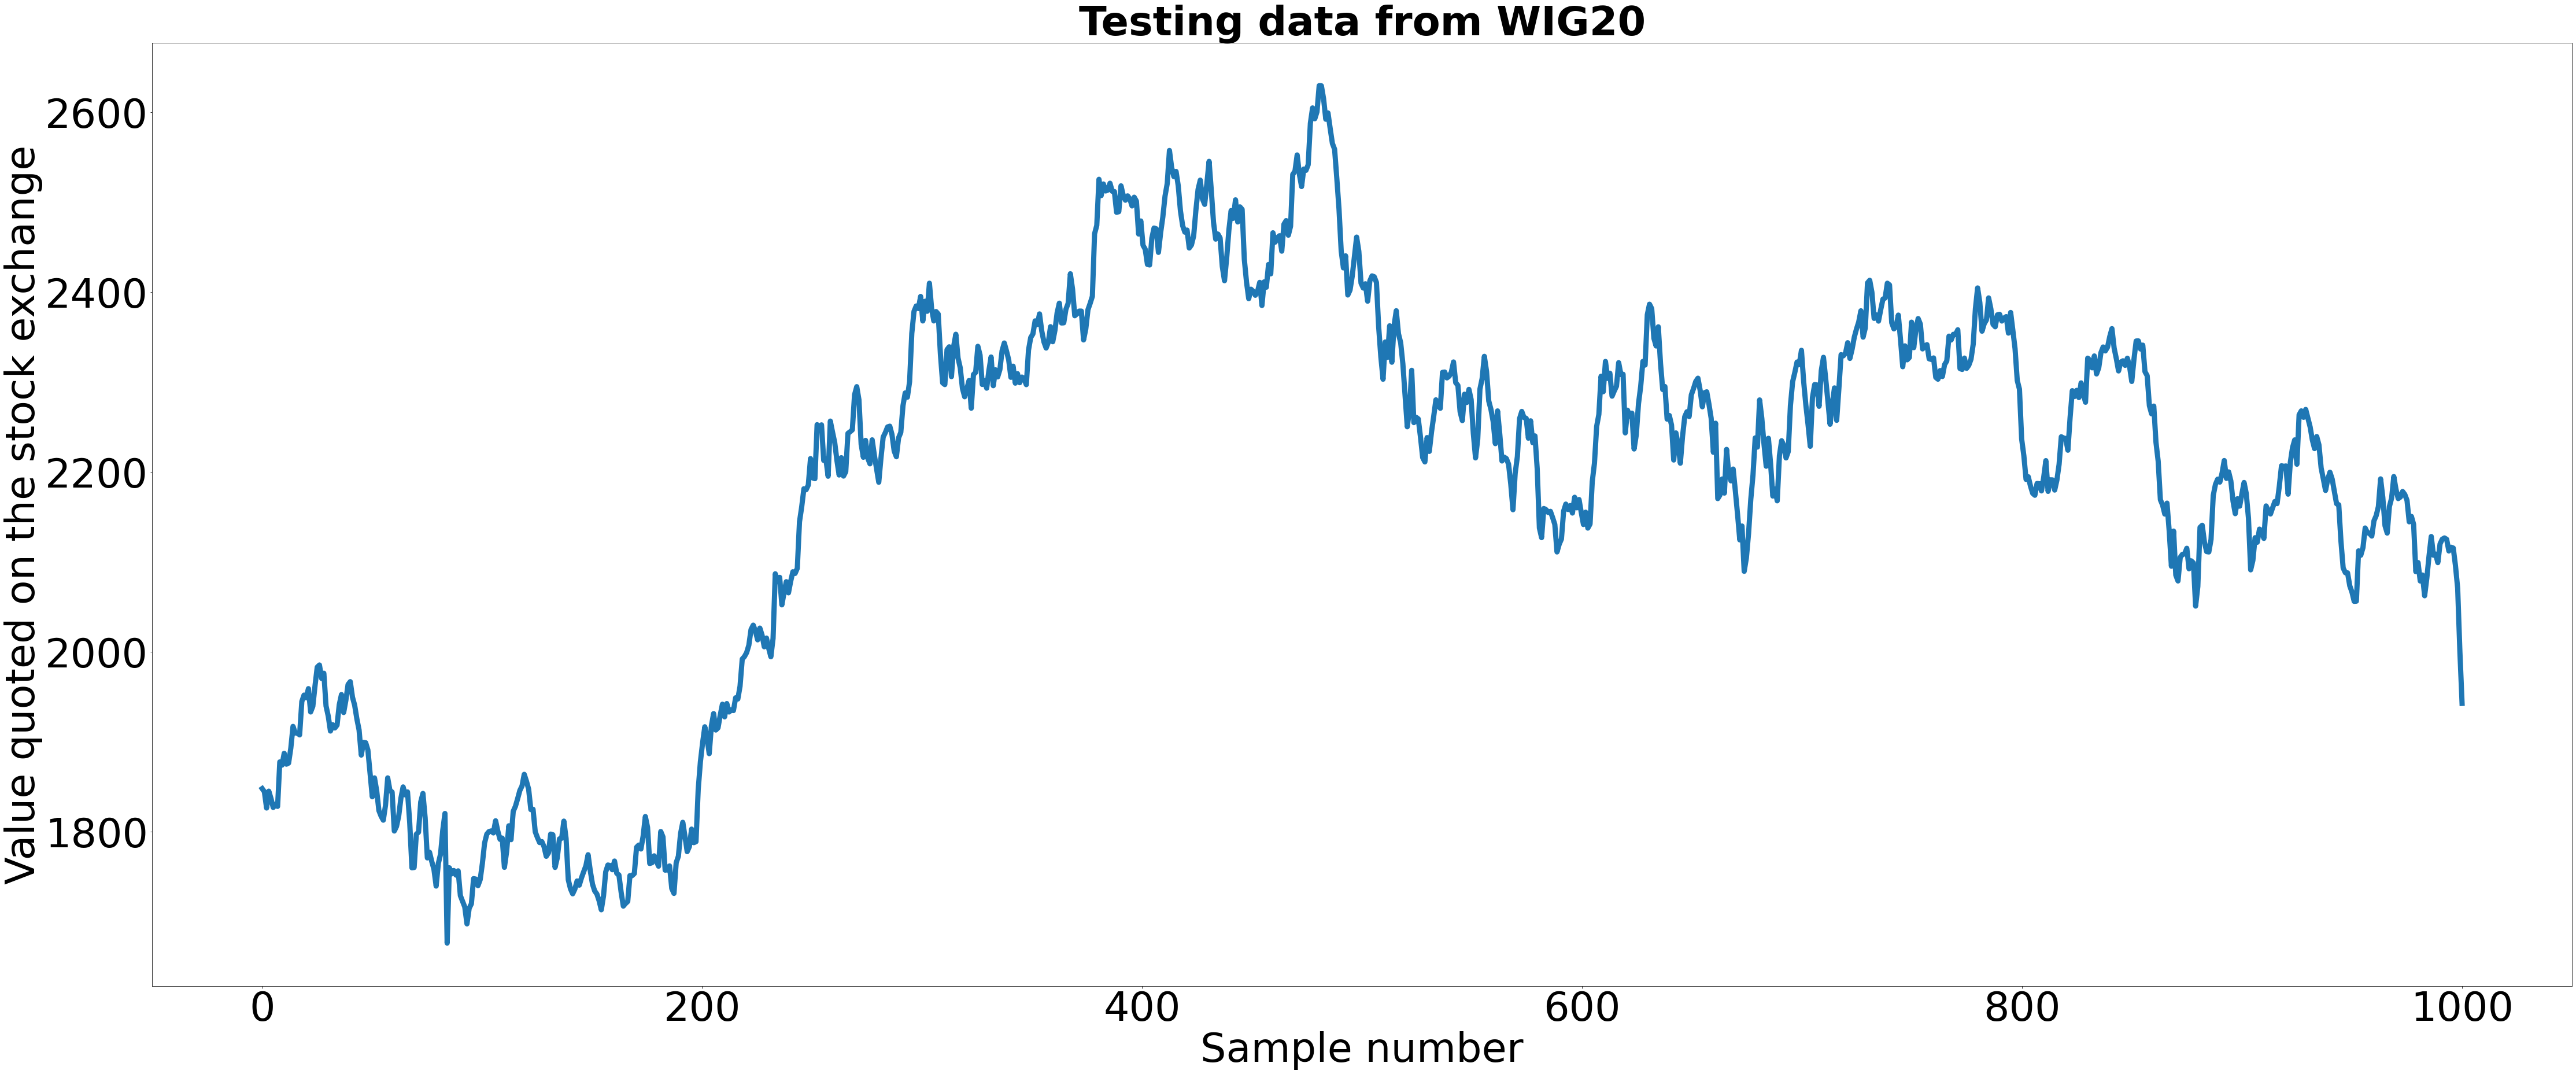

In [19]:
    plt.rcParams["figure.figsize"] = (75,30)
    data_test = pd.read_csv('wig20_test.csv', delimiter=',', header = None) 
    data_train = pd.read_csv('wig20_train.csv', delimiter=',', header = None)    
    data = list(data_test[0])
    x = np.linspace(0,1000, 1000)
    plt.plot(x, data, linewidth = 9)
    plt.ylabel('Value quoted on the stock exchange', fontsize=70)
    plt.xlabel('Sample number', fontsize=70)
    plt.xticks(fontsize=70)
    plt.yticks(fontsize=70)
    plt.title('Testing data from WIG20', fontsize = 70, fontweight="bold")
    plt.show()

## Data preparation

In [20]:

    scaler = MinMaxScaler()
    data_train = scaler.fit_transform(data_train)
    data_test = scaler.transform(data_test)
    
    data_train = np.array(data_train);
    data_test = np.array(data_test);
    
    X_train = []
    Y_train = []
    
    for i in range(60, data_train.shape[0]):
        X_train.append(data_train[i-60:i])
        Y_train.append(data_train[i,0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    
    X_test = []
    Y_test = []

    for i in range(60, data_test.shape[0]):
        X_test.append(data_test[i-60:i])
        Y_test.append(data_test[i,0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

## Model building

In [21]:
    model = Sequential()
    model.add(LSTM(units=60, activation='relu', return_sequences = True, input_shape = (X_train.shape[1],5)))

    model.add(LSTM(units=60, activation='relu', return_sequences = True))

    model.add(LSTM(units=80, activation='relu', return_sequences = True))

    model.add(LSTM(units=120, activation='relu'))

    model.add(Dense(units = 1))
    
    model.compile(optimizer = 'adam', loss = 'mse')

## Trening or file loading

In [22]:
    if path.exists('model.h5'):
        model.load_weights('model.h5')
    else:
        model.fit(X_train, Y_train, epochs = 60, batch_size = 32)
        model.save_weights('model_new.h5')

Train on 5707 samples
Epoch 1/60
5707/5707 [==============================] - 34s 6ms/sample - loss: 0.0103
Epoch 2/60
5707/5707 [==============================] - 31s 5ms/sample - loss: 8.0644e-04
Epoch 3/60
5707/5707 [==============================] - 29s 5ms/sample - loss: 7.7819e-04
Epoch 4/60
5707/5707 [==============================] - 28s 5ms/sample - loss: 5.3503e-04
Epoch 5/60
5707/5707 [==============================] - 29s 5ms/sample - loss: 4.9169e-04
Epoch 6/60
5707/5707 [==============================] - 28s 5ms/sample - loss: 4.1246e-04
Epoch 7/60
5707/5707 [==============================] - 29s 5ms/sample - loss: 3.0081e-04
Epoch 8/60
5707/5707 [==============================] - 29s 5ms/sample - loss: 2.7617e-04
Epoch 9/60
5707/5707 [==============================] - 29s 5ms/sample - loss: 2.2007e-04
Epoch 10/60
5707/5707 [==============================] - 29s 5ms/sample - loss: 1.7664e-04
Epoch 11/60
5707/5707 [==============================] - 28s 5ms/sample - loss: 1

## Results Presentation

In [23]:
    Y_pred = model.predict(X_test)
    Y_pred = Y_pred/(scaler.scale_[0])

    monotonicity = 0
    for i in range(61, 1000):
        if(Y_pred[i-60] <= Y_pred[i-1-60] and data[i] <= data[i-1]):
            monotonicity+=1
        elif(Y_pred[i-60] > Y_pred[i-1-60] and data[i] > data[i-1]):
            monotonicity+=1
    print('Preservation of monotonicity as a percentage: ' + str(round((monotonicity/939)*100,2)))
    buy_file, sell_file = trading_with_prediction(data, Y_pred)

Preservation of monotonicity as a percentage: 81.15
The amount of paid sales as a percentage (such that we sell more than we bought): 85.02
Profit in percent: 1954.52


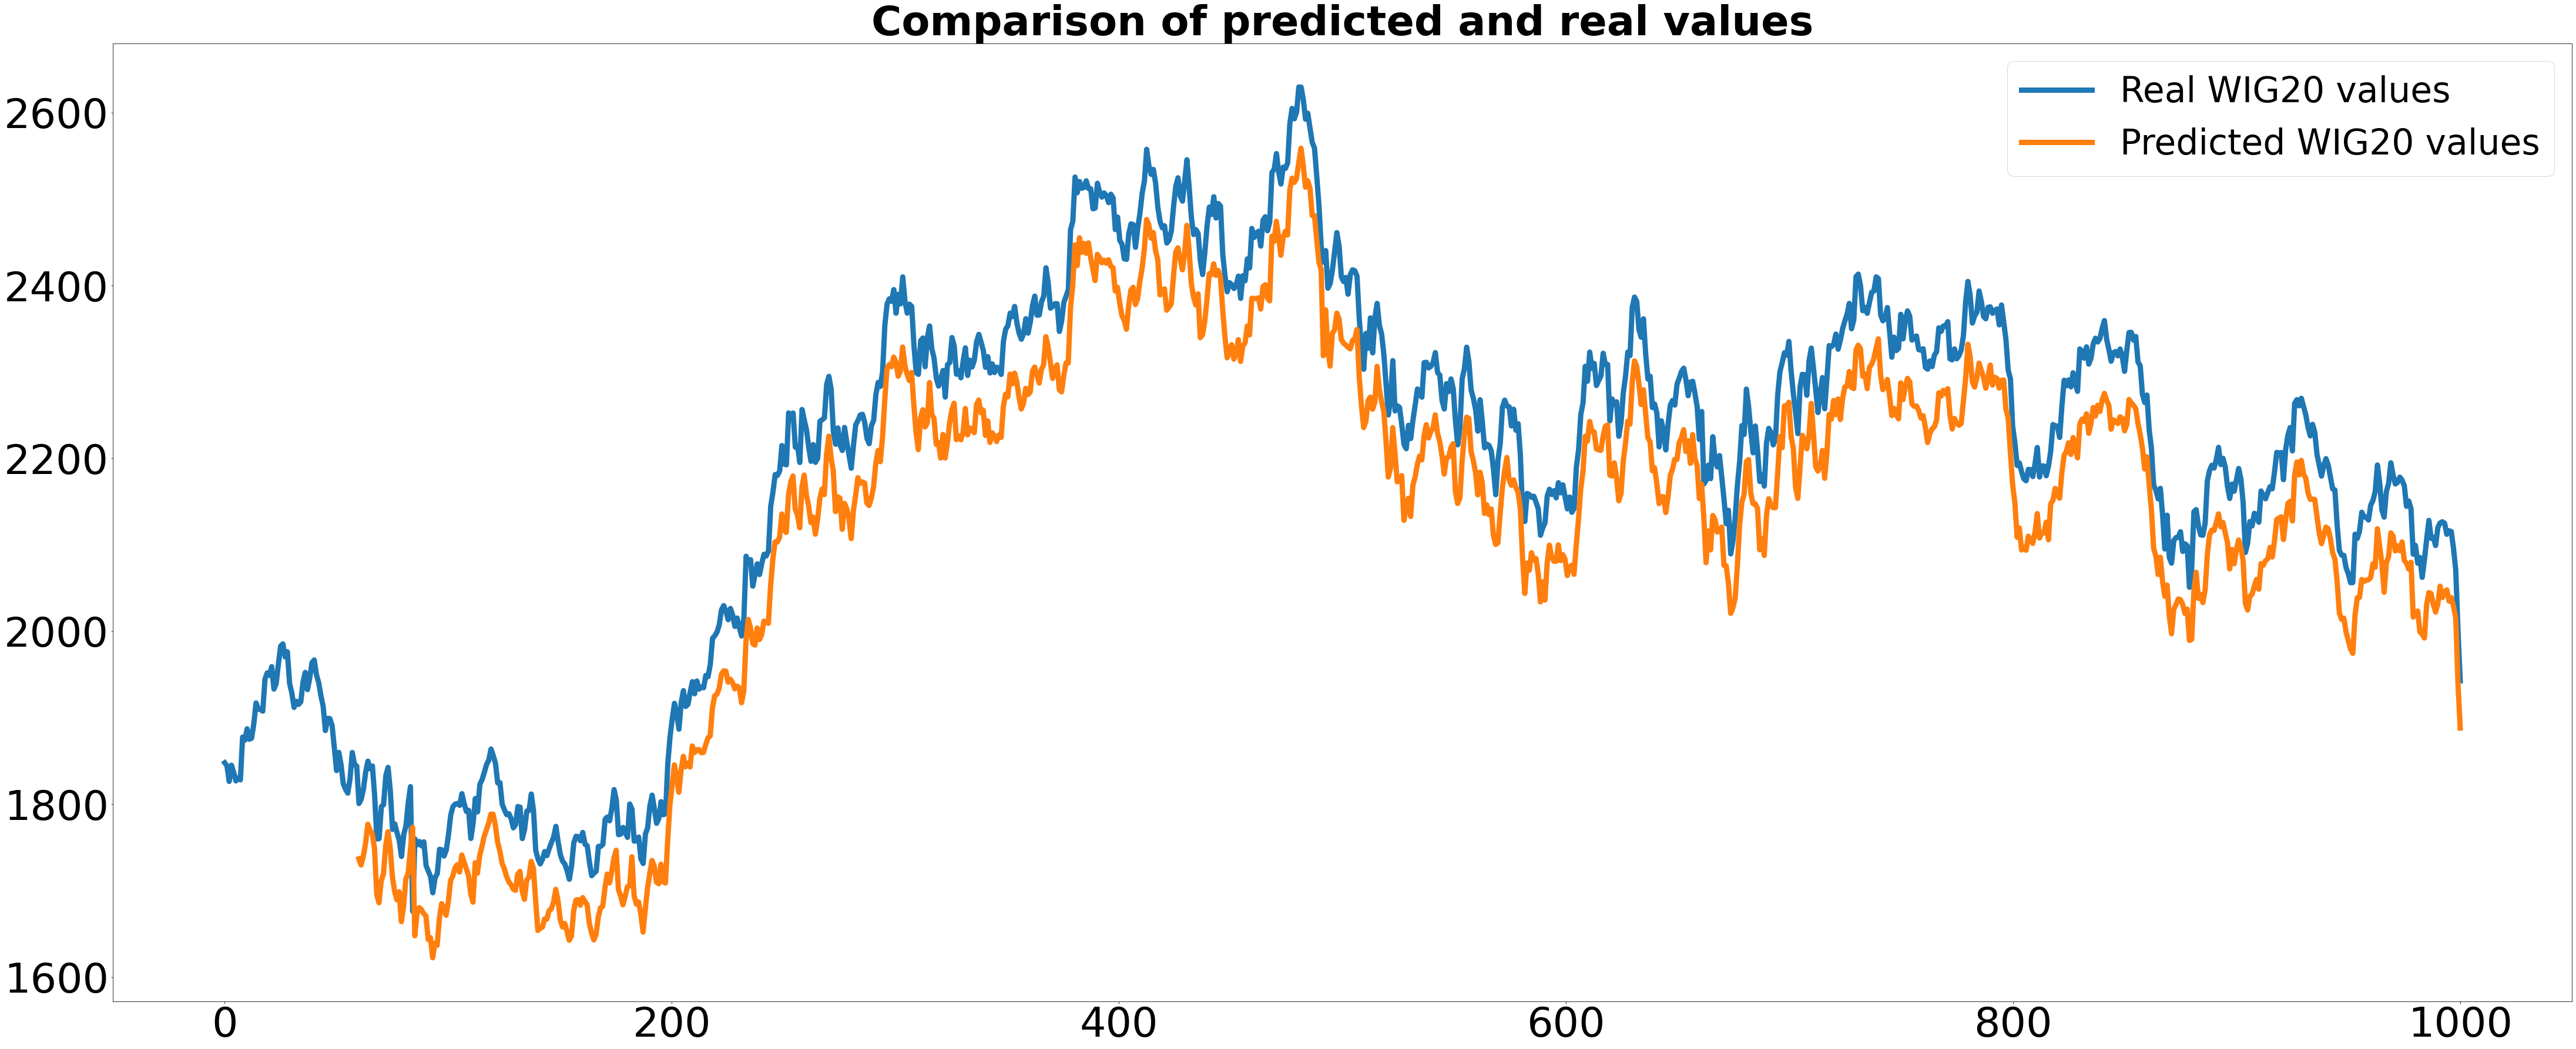

In [24]:
    x_pred = np.linspace(60,1000,940)
    x_test = np.linspace(0,1000, 1000)
    buy = pd.read_csv(buy_file, header = None)
    sell = pd.read_csv(sell_file, header = None)
    plt.plot(x_test, data, label = 'Real WIG20 values', linewidth = 9)
    plt.plot(x_pred, Y_pred, label = 'Predicted WIG20 values', linewidth = 9)
    plt.title('Comparison of predicted and real values', fontsize = 70, fontweight="bold")
    plt.xticks(fontsize=70)
    plt.yticks(fontsize=70)
    plt.legend(prop={"size":60})
    plt.show()

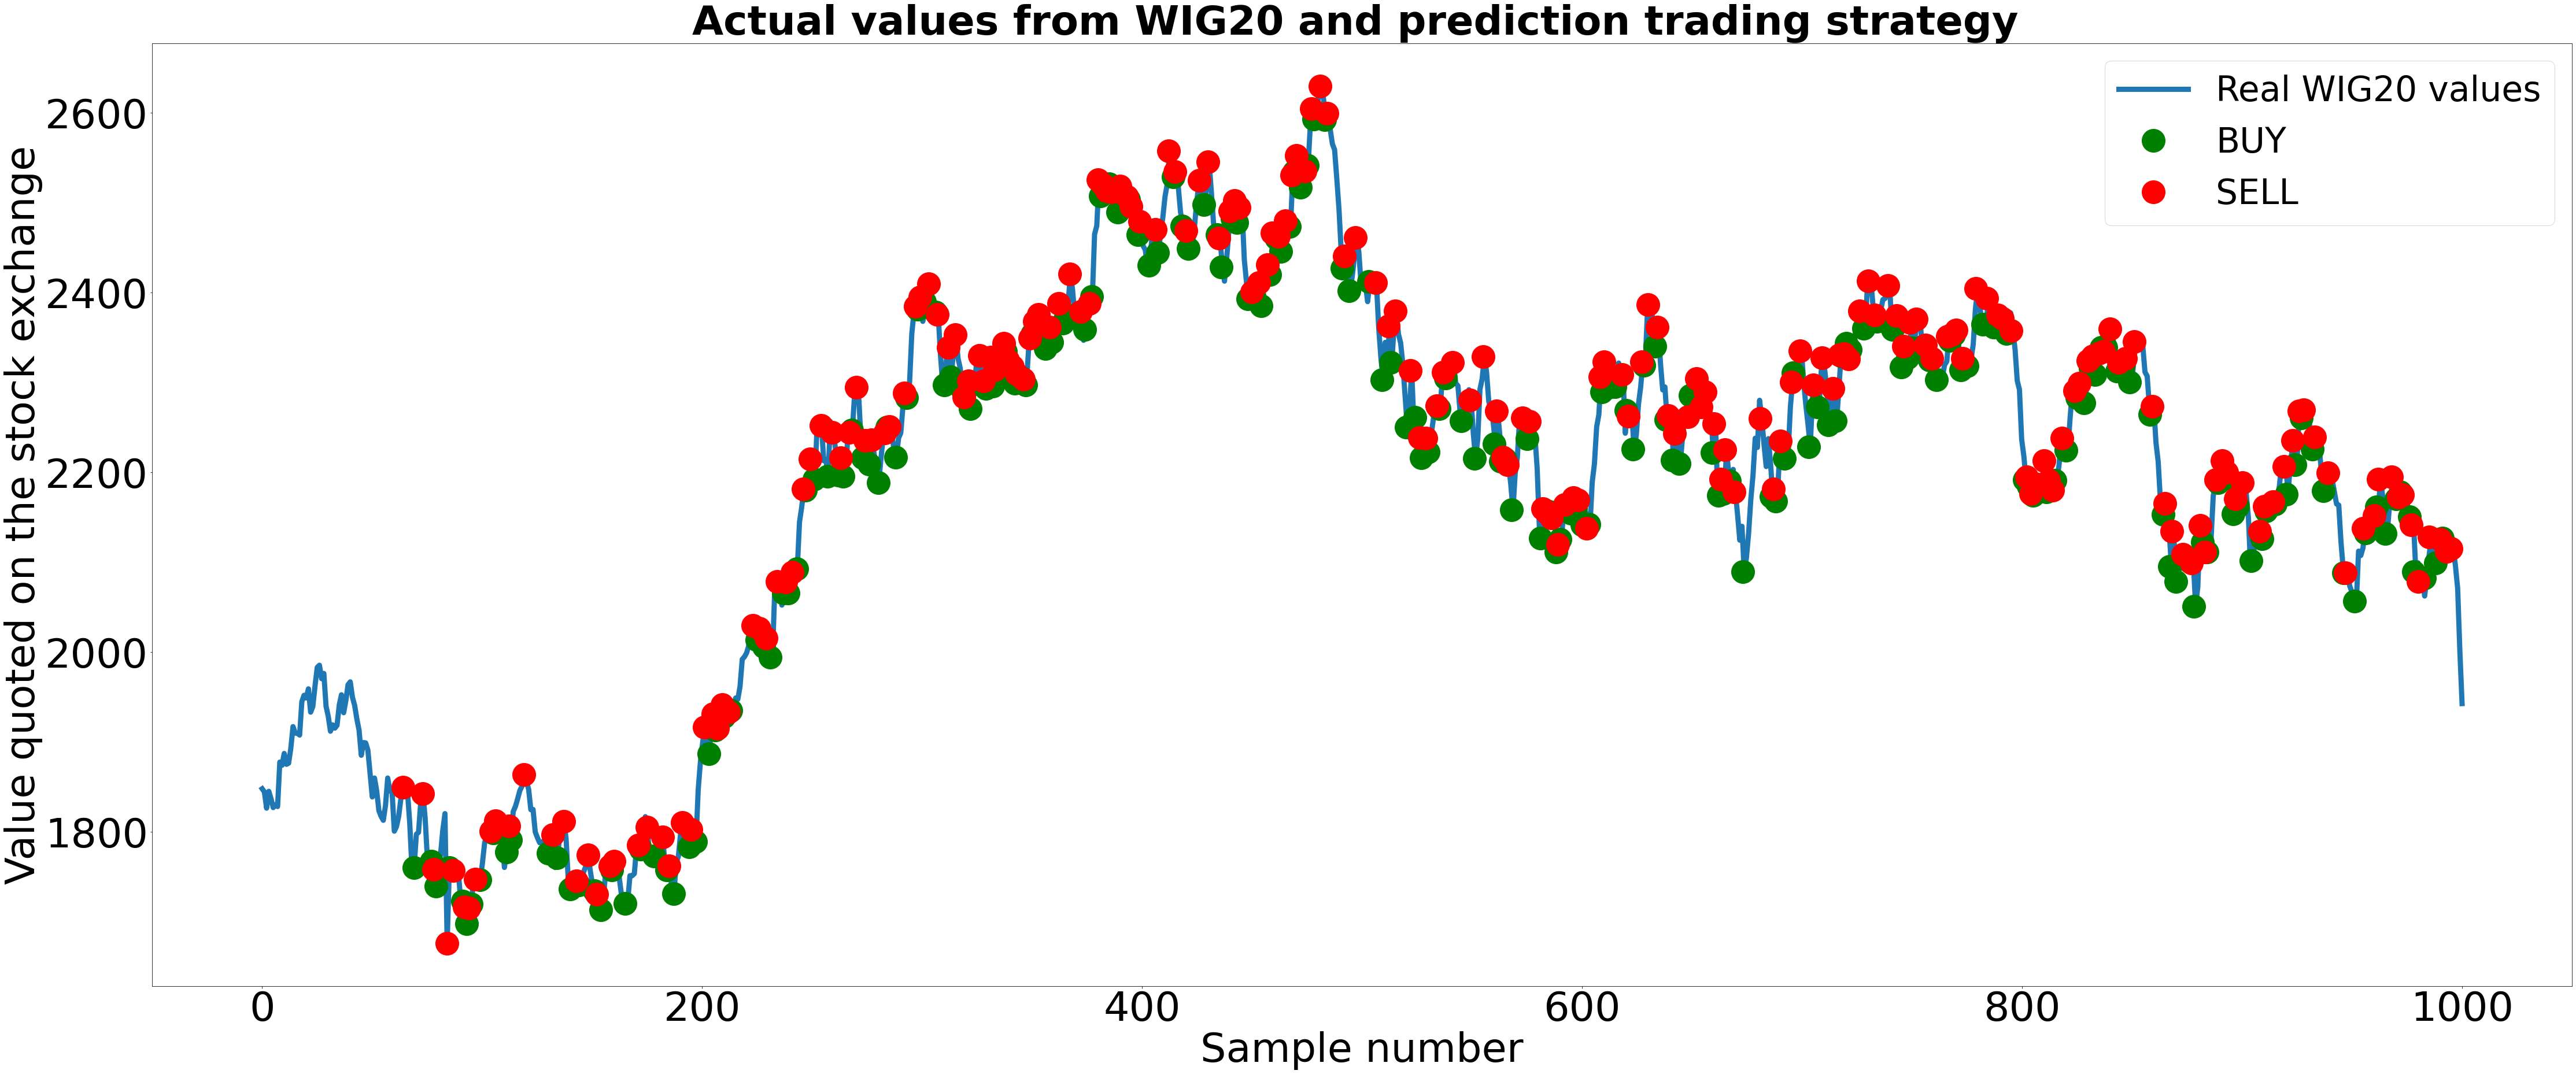

In [25]:
    x_test = np.linspace(0,1000, 1000)
    buy = pd.read_csv(buy_file, header = None)
    sell = pd.read_csv(sell_file, header = None)
    plt.plot(x_test, data, label = 'Real WIG20 values', linewidth = 9)
    plt.plot(buy[0], buy[1], 'go', label='BUY', markersize = 40)
    plt.plot(sell[0], sell[1], 'ro', label='SELL', markersize = 40)
    plt.title('Actual values from WIG20 and prediction trading strategy ', fontsize = 70, fontweight="bold")
    plt.xlabel('Sample number', fontsize=70)
    plt.ylabel('Value quoted on the stock exchange', fontsize=70)
    plt.xticks(fontsize=70)
    plt.yticks(fontsize=70)
    plt.legend(prop={"size":60})
    plt.show()